<h1><center>AM207 Final Project</center></h1>
<h2><center>
    LAGGING INFERENCE NETWORKS AND POSTERIOR COLLAPSE IN VARIATIONAL AUTOENCODERS<br><br>
    Jessica Wijaya, Will Fried, Angie Dinh, Shucheng Yan
    </center></h2>
<h3><center>
    December 19, 2020
</center></h3>

## Problem statement

At first glance, training a variational autoencoder (VAE) seems pretty straightfoward -- it simply involves evaluating the evidence lower bound (ELBO) of the marginal data log likelihood and maximizing this ELBO by performing gradient descent on the parameters of the inference and generative networks, which are denoted by $\phi$ and $\theta$, respectively. However, it turns out that that in practice, a VAE trained using this standard procedure is prone to get stuck in a degenerate state. In this local optimum, the approximate posterior outputted by the inference network $q_{\phi}(\mathbf{z}|\mathbf{x})$ fails to capture any informative features contained in the input $x$ and instead regresses to the prior distribution $p(z)$ of the latent variable $z$. Because the latent variable produced by the encoder is meaningless, the decoder learns to ignore the latent variable entirely. Eventually, the true model posterior $p_{\theta}(z|x) = \frac{p_{\theta}(x|z)p(z)}{p_{\theta}(x)}$ aligns with the approximate posterior by reverting back to the prior distribution $p(z)$ as well. This undesirable state is called posterior collapse and results in a useless model that hasn't learned any meaningful latent representation of the training data. 

Based on empirical results, the risk of posterior collapse appears to be highest for VAE models where the generator is parametrized by a strong autoregressive neural network such as an LSTM or PixelCNN, on when the data is discrete, such as when dealing with text.

The goal of the paper is simply to figure out how to avoid encountering posterior collapse during training. 

## Importance of problem

The utility of a VAE is measured by the extent to which the model is able to learn a useful latent representation of the input data, whether it be images, text or a high-dimensional set of features. Because posterior collapse results in an inference network that ignores $x$ and a generative network than ignores $z$, it poses a threat to this goal. Importantly, posterior collapse is not something that can be easily be averted, such as by reinitializing the weights or slightly tweaking the VAE architecture. Instead, it must be addressed directly. 

## Existing work

This problem was described in (Bowman et al., 2016) to occur when they combined LSTM and VAE for text modeling. They solved it using regularization methods, where they increased the weight of KL term
(between estimated posterior and prior) up to one in the initial "warm-up" period. However, this method didn't work on complex text datasets and large LSTM encoders. 

Expanding on this work, many other works propose reducing the effect of the KL term. For example, Higgins et al., 2017 proposes the β-VAE that uses a hyperparameter for the KL weight, in order to put a minimum constraint on the KL term. These approaches enable more use of the latent variable; however, they aren't great for density estimation performance. 

Other research explores the "amortization gap" - i.e the differences of the ELBO due to all the inference network sharing parameters. They mostly try to narrow this gap by combining instance-specific with amortized variational inference (Hjelm et al., 2016; Krishnan et al., 2018; Kim et al.,
2018; Marino et al., 2018). Kim et al., 2018 proposes a method called SA-VAE, which adds in instance-specific variational inference and has shown to solve posterior collapse. 

Other authors comes up with a few different methods including: new regularizers (Zhao et al., 2017;
Goyal et al., 2017; Tolstikhin et al., 2018; Phuong et al., 2018), using weaker decoders (Yang et al., 2017; Semeniuta et al., 2017), lossy input (Chen et al., 2017), using other latent variable connections (Dieng et al., 2017; 2018; Park et al., 2018), or using a different prior (Tomczak & Welling, 2018; Xu & Durrett, 2018).

## Contribution

This paper's approach is different from previous work because they did not change the ELBO, and thus still essentially train an MLE. They only modify the algorithm to slow down the decoder, allowing the encoder to catch up and the decoder to make use of the encoder. The algorithm is also quite simple; as a result, it is also fast in training time. 

The authors run an experiment of their algorithm on the Yahoo and Yelp datasets, and compare it with previous algorithms. This algorithm outperform almost all previous algorithms in negative log likelihood. Its other metrics, such as KL and mutual information (between latent variable and decoder), are also good. This approach performs similarly to Kim et al.'s SA-VAE method in all these metrics, but is 5x faster in training time. 

## Technical content (high level)

The contribution of the paper is motivated entirely by intuition about what happens during the early stages of VAE training. The following form of the ELBO is the most illuminating: 

$$ L(\mathbf{x}, \theta, \phi) = log p_{\theta}(\mathbf{x}) - D_{KL}(q_{\phi}(\mathbf{z}|\mathbf{x}) || p_{\theta}(\mathbf{z}|\mathbf{x}))$$ 

In this formulation of the ELBO, the first term represents the marginal data log likelihood and encourages the decoder to accurately reconstruct the input data, while the second term represents the KL divergence between the true model posterior and the approximate model posterior and encourages these two distributions to be alike.

The overall goal of training the VAE is to learn a latent representation $z_n$ corresponding to each $x_n$ that captures the useful information in $x_n$. The marginal data log likelihood term of the ELBO pushes the VAE to learn this meaningful latent representation -- if $z_n$ doesn't convey much useful information about $x_n$, then the best the decoder can do is to produce a crude distribution that is representative of an average value of $x$ in the training set. Such an output distribution would result in a relatively low observed data log-likelihood. On the other hand, if $z_n$ captures valuable information about $x_n$, then the decoder can produce a distribution that is tailored specifically to $x_n$ and can thus achieve a relatively high observed data log-likelihood across the $x_n$ in the training set. 

However, because the weights in the encoder and decoder are initialized randomly, there is no significant relationship between $z$ and $x$ in the encoder at the start of training. Instead, $\mathbf{z}$ is nearly independent of $\mathbf{x}$ because for a given value of $x$, the encoder is essentially outputting a random value for $z$ that doesn't capture the latent representation of $x$. Therefore, once training starts, the approximate posterior $q_{\phi}(\mathbf{z}|\mathbf{x})$ doesn't deviate substantially from its prior of $N(0, I)$. This is the case because given the penalty incurred for diverging from the prior, the encoder is only incentivized to output latent variables that have low likelihood under the prior if doing so would transmit information to the decoder that would significantly help the decoder reconstruct the original data. However, because $x$ and $z$ are initially independent in the encoder and the decoder, there is no reason for the encoder to stray from the prior.  
Meanwhile, in order to increase the marginal data log likelihood term, gradient descent causes the decoder to learn weights that approximate $x$ without using $z$. As this learning process continues, $p_{\theta}(x|z) \approx p_{\theta}(x)$ changes. This, in turn, means that the true posterior $p_{\theta}(\mathbf{z}|\mathbf{x})$, which is proportional to $p(z)p_{\theta}(x|z)$ becomes increasingly different from the approximate prior, which, as explained above, remains anchored at the prior. As a result, the KL divergence term increases in magnitude and has a larger influence on the gradient. Eventually, the decoder learns weights that come close to maximizing the observed data log likelihood subject to the limitation that $z$ conveys no useful information about $x$. At this point, the gradient associated with the KL divergence term dominates and pushes the true posterior and approximate posterior into alignment. To achieve this, the gradient simply drives the true posterior to the prior. Because the decoder doesn't make use of $z$ in the first place, this doesn't impede the decoder's ability produce an average representation of the training data. 

At this point, the VAE is in a state of posterior collapse as the model still hasn't learned a useful latent encoding. And unfortunately, this state is locally optimal because both terms in the ELBO have been locally optimized -- from the perspective of the marginal data log likelihood term, the VAE is doing the best it can at reconstructing $x$, while from the persepctive of the KL divergence term, the approximate and true posteriors completely overlap so there's no room for improvement. Therefore, performing additional rounds of gradient descent don't help to escape from this state of posterior collapse.

The authors validate this reasoning by observing the behavior of the encoder and decoder over the course of training for a simple VAE model. This toy example consists of an LSTM encoder and decoder and a one-dimensional latent variable, such that it's easy to visualize the mean of the true posterior and approximate posterior at different stages of the training process. The results are displayed below:  

![](figs/collapse.png)

In the figure above, the x-axis represents the mean of the true posterior ($p_{\theta}(z|x) = \frac{p_{\theta}(x|z)p(z)}{p_{\theta}(x)}$), while the y-axis represents the mean of the approximate posterior ($q_{\phi}(z|x)$). Each "X" corresponds to different training point. Initially, both of these means are centered at the origin, as shown in the left-most plot. The reason for this is that the weights of the encoder and decoder LSTMs are randomly initialized from a uniform distribution with a mean of zero, so by symmetry, the expected output of the encoder and decoder is zero. The second plot shows that when training starts, the points spread out across the x-axis, which indicates that the true posterior does not suffer from posterior collapse. This is consistent with the discussion above about how the observed data log likelihood term pushes the decoder to capture the average of the training examples. On the other hand, none of the points in the second plot spread out along the vertical axis, which indicates that the encoder is in a state of inference collapse and that the approximate posterior doesn't digress from the prior. Finally, the third and fourth plots show that as training proceeds the true posterior gradually shrinks back toward the prior such that the true posterior and approximate posterior are in agreement with each other. 

## Technical content (details)

The discussion above reveals that posterior collapse is caused by the failure of the encoder to produce a meaningful latent representation or, in other words, to approximate the true posterior. This suggests that standard VAE training, which involves simultaneously differentiating the ELBO with respect to the weights of the encoder and decoder and simultatenously updating the weights of both networks, causes the encoder to lag far behind the true posterior, which is a moving target that changes during every iteration. This realization, in turn, motivates the introduction of a very simple modification to the standard VAE training algorithm: rather than training the encoder and decoder simultaneously, we should update the two networks separately. First, we should train the encoder for as long as it takes to catch up to the true posterior and only then should we proceed to update the decoder, which will cause the true posterior to shift once more.

To be concrete, standard VAE training involves repeating the following three steps until convergence:
1. Sample a random data minibatch from the training set
2. Use automatic differentiation to compute the gradient of the elbo with respect to the weights of the encoder and decoder.
3. Update the weights of the encoder and decoder by taking a step in the direction opposite of the gradient. 

The proposed modification, called aggressive training, converts this procedure into a two stage, coordinate ascent-style algorithm:

1. Force the approximate posterior to catch up to true posterior by repeating the following three steps until the encoder converges:
    1. Sample a random data minibatch from the training set
    2. Compute the gradient of the elbo with respect to the weights of the encoder
    3. Update the weights of the encoder by taking a step in the direction opposite of the gradient
2. Train the decoder by repeating the following three steps once:
    1. Sample a random data minibatch from the training set
    2. Compute the gradient of the elbo with respect to the weights of the decoder
    3. Update the weights of the decoder by taking a step in the direction opposite of the gradient
    
The diagram below illustrates what's taking place during the aggressive training:

![](figs/aggressive.png)

Each horizontal shift reflects the change in the true posterior that occurs each time the decoder is updated (i.e. step 2 of the algorithm). At this point, the approximate posterior outputted by the encoder no longer matches the true posterior. Therefore, the next step is to train the encoder network for as long as it takes to capture the new true posterior (i.e. step 1 of the algorithm). This update to the approximate posterior is reflected by the vertical shift, which pushes the points back toward the diagonal line such that the true posterior and approximate posterior are in alignment. 

While the modified training algorithm presented above ensures that the approximate posterior keeps up with the true posterior, it is significantly more computational intensive that the original algorithm because it involves updating the encoder weights an arbitrary number of times during each iteration. Therefore, we only want to carry out the modified algorithm when we're concerned that the model will fall into a state of posterior collapse. On the other hand, if we're confident that the model will avoid posterior collapse, then we should revert back to the original algorithm where the encoder and encoder are trained together. The final step, therefore, is to devise a way to assess the risk of suffering from posterior collapse at an arbitrary stage of the training process. 

The fact that posterior collapse occurs when the encoder fails to learn a meaningful latent representation of the training data means that we need to develop a metric that quantifies the degree to which the encoder is achieving it's goal. The authors propose using the mutual information $I_q$ between $x$ and $z$ under the approximate posterior $q_{\phi}(\mathbf{z}|\mathbf{x})$. In information theory, the mutual information between two random variables measures the dependence between the random variables or, in other words, the information about one random variable provided by the other random variable. Therefore, the higher the mutual information between x and z, the more the encoder is learning a latent representation that is tailored to each training example, and the more confident we are that the approximate posterior is no longer concentrated at the prior. On the other hand, a low mutual information between x and z indicates that x and z are still nearly independent, which, as explained above, means that the approximate posterior is lagging far behind the true posterior. 

This mutual information metric is easily incorporated into the modified training algorithm: after each cycle that alternates between training the encoder and training the decoder, the mutual information is calculated on a held-out validation set. When the mutual information stops increasing, the algorithm reverts back to standard VAE training, which continues until the convergence of the entire VAE.

The paper presents the following formulation of the mutual information between $x$ and $z$ under $q_{\phi}(\mathbf{z}|\mathbf{x})$:

$$ I_q = E_{\mathbf{x} \sim p_d(\mathbf{x})}[D_{KL}(q_{\phi}(\mathbf{z}|\mathbf{x})||p(\mathbf{z})] - D_{KL}(q_{\phi}(\mathbf{z})||p(\mathbf{z})$$

where $\mathbf{x} \sim p_d(\mathbf{x})$ denotes the empirical distribution defined by the training set. However, in the authors' implementation of their methodology, they compute the following alternative form of the mutual information:

$$ I_q = E_{\mathbf{x} \sim p_d(\mathbf{x})}[E(q_{\phi}(\mathbf{z}|\mathbf{x})log(q_{\phi}(\mathbf{z}|\mathbf{x}))] - E_{\mathbf{x} \sim p_d(\mathbf{x})}[E(q_{\phi}(\mathbf{z}|\mathbf{x})log(q_{\phi}(\mathbf{z}))]$$

Finally, the authors verify the effectiveness of agressive training by using their proposed training procedure on the toy VAE model with one latent variable. The results are displayed below:

![](figs/diagonal.png)

As before, the first plot shows that the means of both the true posterior and approximate posterior are located at the origin upon initialization. The rest of the plots show that all the points lie roughly along the diagonal, which indicates that the encoder is outputting an approximate posterior than is very close to the true posterior. Overall, this shows that aggressive training has successfully avoided posterior collapsed. 

## Experiments 

Experiments presented in the paper are designed with three goals: 
1. examine whether the proposed aggressive training algorithm indeed prevents posterior collapse.
2. test the algorithm’s efficacy with respect to maximizing predictive log-likelihood compared to other existing approaches.
3. test the algorithm’s training efficiency in terms of training time compared to other existing approaches.

In the experiments, the proposed aggressive training model is compared with a couple of existing state-of-art models for VAE training: 

1. strong neural autoregressive models (LSTM-LM for text and Pixel-CNN for images), 
2. basic VAE
3. VAE with “KL cost annealing” (Bowman et al., 2016; Sønderby et al., 2016)
4. beta-VAE (Higgins et al., 2017)
5. SA-VAE (Kim et al., 2018)

  

Three data sets are used to train, evaluate and compare the performance of the proposed model with existing models mentioned above: 
1. text from Yahoo Corpora (Yang et al., 2017)
2. text from Yelp Corpora (Yang et al., 2017)
3. images from OMNIGLOT (Lake et al., 2015)

The performance of each model is evaluated and reported using the following metrics:
1. negative log likelihood (NLL) as estimated by 500 important weighted samples (Burda et al., 2016)
2. $D_{KL}(q_{\phi}(\mathbf{z}|\mathbf{x})||p(\mathbf{z})$ (KL)
3. mutual information $I_q$ (MI)
4. the number of active units (AU)(Burda et al., 2016) in latent representation

These experiments are conducted to show that the proposed aggressive training model achieved better performance in terms of lower negative log likelihood in VAE structures where posterior collapse is likely to happen. The number of active units (AU) after aggressive training is reported together with NLL to demonstrate that posterior collapse is indeed avoided compared to other models which have zero or many fewer active units after training. Experiments in the paper report both the value and the variance for all the evaluation metrics from each model. The results show that the proposed aggressive training model achieves comparable or better performance than the previous state-of-art models on all three data sets.

## Evaluation

We believe that the work is technically sound as it starts by diving deep into the underlying cause of posterior collapse from a training dynamic perspective before proposing its solution. Based on the intuitions from the alternative form of ELBO, the paper shows how posterior approximation in initial stages of training often lags behind the true model posterior. The paper then examines why such lagging behavior can drive generative models towards posterior collapse after a number of iterations during training. We appreciate that the cause of posterior collapse is well analyzed in the paper first. The aggressive training algorithm is then proposed to show how it can address the fundamental issue in VAE training as clearly revealed in the previous analysis. 

The experiments conducted in the paper use real world text and image data. The results show that the proposed model achieved better performance than a couple of existing state-of-art VAE training models on the same datasets. Although we believe that the proposed method can be used on real data and tasks as the ones demonstrated in the experiments, we do not think that the experimental section is strong enough to sufficiently support its claims. The main reason is that we believe the paper does not provide enough information on the generalizability of the proposed training algorithm across different encoder-decoder architectures, parameter settings, and different data sets. The encoder and decoder network structures used in the experiments are specified with fixed parameters including the number of hidden layers, hidden units, optimizers, learn rates, etc. However, the paper does not discuss the robustness of the algorithm to deal with posterior collapse if any of model settings is changed. This raised our concerns especially when we discovered in our own code implementation that the choice of optimizers can also determine the success of the proposed algorithm in avoiding posterior collapse. The experimental sections only show that the proposed algorithm works on the three real-world datasets trained using a pre-specified enoder-decoder structure without a high-level summary on the algorithm’s generalizability. We would like to see more analysis on why model architectures and hyperparameter settings can also determine the success of the algorithm in avoiding posterior collapse. The experimental section would be more comprehensive if the generalizability and potential failure modes of the proposed algorithm is researched as well.

## Broader Impact

VAE is an innovative generative model to generate new data such as images and text. Its usage in data generation is becoming increasingly important in the machine learning community as getting high-quality and labeled data is difficult. This is especially the case in where advanced deep learning models would usually require a significant amount of data points for training. 
 
In this paper, the authors introduce a new VAE training algorithm which incorporates controlled aggressive inference optimization to resolve the “posterior collapse” issue in VAE training.  To begin with, this paper first provides an in-depth analysis of the underlying mechanism that basic VAE training would run into posterior collapse from the perspective of training dynamics.  This analysis provides the machine learning community a new perspective to understand  the cause of posterior collapses based on the training paradigm that optimizes an alternative form of ELBO.  In the meantime, this analysis would provide machine learning practitioners more insights into what encoder-decoder architectures would be more likely to run into posterior collapse when designing their VAE structures. 
 
In addition, the most common existing approaches for dealing with posterior collapse are centered around “KL cost annealing” where the weight of KL term is treated as a hyperparameter such as in beta-VAE. These approaches would change the ELBO objective during training and therefore they are no longer optimizing a lower bound on the log-likelihood. The proposed aggressive training algorithm in the paper differs fundementally from existing methods as it does not change ELBO objects during training.  As a result, this paper also introduces to the machine learning community a more principled way to deal with posterior collapse which maintains the goal of maximizing log-likelihood through the original form of ELBO.
 
In applications of this aggressive training algorithm, machine learning practitioners  who would like to use this algorithm to avoid posterior collapse in training their VAE models would be the stakeholders. One of the biggest potential risks in applying this algorithm is that the paper does not discuss the generalizability and failure mode of this algorithm. Based on experiments, the paper only presented that the algorithm successfully avoided posterior collapse when trained on some specified data set using some specified encoder-decoder structure. It’s not clear from the paper how generalizable the algorithm would be. We learned from our own implementation that some other factors are also likely to determine the success of this algorithm. To illustrate, if the decoder structure is much more complicated than the encoder structure, it’s unlikely that the algorithm will succeed. At the same time, we found that in some of our experiments, successful application of this algorithm is determined by optimizers and encoder-decoder architectures specified for training. As a result, if machine learning practitioners are not fully aware of the failure mode of this algorithm, it will not be guaranteed that the algorithm will always solve posterior collapse for any model settings. Without a discussion on the model’s generalizability, it makes harder for machine learning practitioners to confidently and safely incorporate this algorithm into their work.

## Implementation

In this section, we implement aggressive training and provide an example where it succeeds in preventing posterior collapse and another example where it fails.

In [1]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import scipy as sp
from scipy.special import logsumexp

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from IPython.display import clear_output

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 22})

### Utils (Functions + Variables)


The synethic data we used in our experiments is a 3-dimensional multivariate normal distribution with a mean 
of $[1,2,3]^T$ and identity covariance. The size of the training set and validation set is 1000 and 100, respectively. 
We used a batch size of 256, so there are roughly 4 batches per epoch.

In [4]:
np.random.seed(207)
mean = np.array([1, 2, 3])
cov = np.eye(len(mean))
X_data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
X_validation = np.random.multivariate_normal(mean=mean, cov=cov, size=100)

In [5]:
batch_size = 256
buffer_size=1000
reg = 1.

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_data, X_data))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_validation, X_validation))
val_dataset = val_dataset.batch(batch_size)


We defined the loss function in terms of the following form of the ELBO:

![](figs/elbo.png)

Note: although we include the option to vary the penalty of the KL-term as is done in $\beta$-VAE, we always set it to 1.

In [6]:
# Define loss
mse = losses.MeanSquaredError()
def vae_loss(x, x_decoded_mean, z_mean, z_log_var, reg):
    xent_loss = mse(x, x_decoded_mean)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    loss = xent_loss + reg*kl_loss
    return loss

In [7]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Returns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) #stdev = 1.
        epsilon.set_shape(z_mean.shape)
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return z

In [8]:
def make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim=1, n_channels = 1):
    '''
    create encoder model as a stack of dense layers and return the built model
    inputs:
    - input_dim: dimension of input data X
    - enc_intermediate_dim: dimensions for the hidden layers 
    - bottleneck_dim: dimension of z

    output: encoder model
    '''
    # input
    input = layers.Input(shape=input_dim)

    encoder_seq = models.Sequential()
    if n_channels > 1: encoder_seq.add(layers.Flatten())
    for i in range(len(enc_intermediate_dim)):
        encoder_seq.add(layers.Dense(enc_intermediate_dim[i], activation='relu', name=f'encoder{i}'))
    x_encoded = encoder_seq(input)

    z_mean = layers.Dense(bottleneck_dim, activation='linear', name='z_mean')(x_encoded)
    z_log_var = layers.Dense(bottleneck_dim, activation='linear', name='z_log_var')(x_encoded) 
    encoder = models.Model(inputs=input, outputs=[z_mean, z_log_var], name='encoder')

    return encoder
    
def make_decoder(input_dim, dec_intermediate_dim, bottleneck_dim=1, n_channels = 1):
    '''
    create decoder model as a stack of dense layers 
    inputs:
    - input_dim: dimension of input data X 
    - dec_intermediate_dim: dimensions for the hidden layers 
    - bottleneck_dim: dimension of z

    output: decoder model
    '''
    
    if n_channels > 1:
        flat_dim = np.product(input_dim)

    decoder_seq = models.Sequential(name='decoder')
    decoder_seq.add(layers.Input(shape=bottleneck_dim))
    
    for i in range(len(dec_intermediate_dim)):
        decoder_seq.add(layers.Dense(dec_intermediate_dim[i], activation='relu', name=f'decoder{i}'))

    if n_channels > 1:
        decoder_seq.add(layers.Dense(flat_dim, activation='sigmoid'))
        decoder_seq.add(layers.Reshape(input_dim))
    else:
        decoder_seq.add(layers.Dense(input_dim))

    return decoder_seq


In [9]:
def sample_latent_variable(latent_mean, latent_logstd):
    '''return samples from normal distributions with given mean and standard deviation (log scale)'''
    return np.random.randn(*latent_mean.shape) * np.exp(latent_logstd) + latent_mean
    
def diag_gaussian_log_density(x, mu, latent_logstd):
    '''calculate the log density of multidimensional normal distribution'''
    return np.sum(sp.stats.norm.logpdf(x, mu, np.exp(latent_logstd)), axis=-1)

def make_latent_plot1D(X_data, encoder, decoder, ax, n=100, min_z=-10, max_z=10, stride=0.01):
    '''
    Helper function to create plot of the posterior mean space, 
    i.e. to compare the true mu (from the decoder) vs approx mu (from the encoder)
    
    note: it only works if dimension of z = 1.
    '''
    X_samples = X_data[np.random.choice(len(X_data), size=n, replace=False)]
    z_points = np.linspace(min_z, max_z, int((2 * max_z / stride)))
    approx_mu, _ = encoder(X_samples)
    approx_mu = approx_mu.numpy()

    true_mu = []

    for i in range(n):
        X = X_samples[i, :]
        posterior_probs =[]
        log_prior = sp.stats.norm.logpdf(z_points, 0., 1.)
        output_mean = decoder(z_points.reshape(-1,1)).numpy()
        log_likelihood = diag_gaussian_log_density(X, output_mean, 0. )
        posterior_probs = np.exp(log_prior + log_likelihood)

        posterior_probs = np.array(posterior_probs) / np.sum(posterior_probs)   
        true_mu.append(np.sum(z_points * posterior_probs))

    max_val = 3
    ax.set_xlim((-max_val, max_val))
    ax.set_ylim((-max_val, max_val))
    ax.scatter(true_mu, approx_mu, color='r', marker='x')
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax.plot([-max_val, max_val], [-max_val, max_val], color='purple', linestyle='--', linewidth=2)
    ax.set_xlabel('true mu')
    ax.set_ylabel('approximate mu')

    return true_mu, approx_mu, plt.figure, ax

## Implementation of Comprehensive Training (Aggressive + Basic Training)

In [10]:
def mutual_info(encoder, X_validation):
    '''
    Calculate the mutual information between z and X, 
    according to the implementation from the author of the paper: https://github.com/jxhe/vae-lagging-encoder
    '''
    z_mean, z_log_var = encoder(X_validation)
    
    x_batch, nz = z_mean.shape
    neg_entropy = (-0.5 * nz * np.log(2 * np.pi) - 0.5 * (1 + z_log_var.numpy()).sum(-1)).mean() 

    z_samples = Sampling()([z_mean, z_log_var])
    z_samples = z_samples.numpy().reshape(z_samples.shape[0], 1, z_samples.shape[1])
    
    mu = np.expand_dims(z_mean, axis=0).shape
    dev = z_samples - mu
    var = np.exp(z_log_var)
    
    log_density = -0.5 * ((dev ** 2) / var).sum(-1) - 0.5 * (nz * np.log(2 * np.pi) + z_log_var.numpy().sum(-1))
    log_qz = logsumexp(log_density, axis=1) - np.log(x_batch)

    return neg_entropy - log_qz.mean(-1)

In [11]:
def basic_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes, 
                   X_data=X_data, epochs=20, n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):
    '''
    Train the encoder and decoder with regular/basic training 
    (i.e., train the encoder and decoder and update their weights at the same time)
    '''
    
    freq_plot = int(epochs/n_plots) #parameter for plotting
    
    MI_list = [mutual_info(encoder, X_validation)] #stores the list of mutual information values between X and z
    
    # make the plot at 0th epoch
    if show_plot :
        true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)

    for epoch in range(epochs):
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, _) in enumerate(train_dataset):

            # Train the encoder & decoder at the same time
            with tf.GradientTape() as tape:
                z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                z_samples = Sampling()([z_mean, z_log_var]) # sample z
                x_decoded = decoder(z_samples) # reconstruct x from z samples

                loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg) #calc loss for the given batch
            
            # update the encoder and decoder weights with user given optimizer
            grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
            enc_optimizer.apply_gradients(zip(grads[:len(encoder.trainable_weights)], encoder.trainable_weights ))
            dec_optimizer.apply_gradients(zip(grads[len(encoder.trainable_weights):], decoder.trainable_weights))

        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)
        
        # store the mutual information value to the list
        MI_list.append(mutual_info(encoder, X_validation))
        
    if show_plot:
        return encoder, decoder, MI_list, fig, ax
    else:
        return encoder, decoder, MI_list


In [12]:
def comprehensive_training(encoder, decoder, enc_optimizer, dec_optimizer, train_dataset, vae_loss, axes, 
                           X_data=X_data, epochs=100, min_epochs_aggressive=30, patience=10,
                           n_plots=4, make_latent_plot1D=make_latent_plot1D, show_plot=True):
    '''
    This training mode comprises of 2 algorithms: aggressive and basic training
    
    With Aggressive Training, we train the encoder and decoder (and update their weights) separately.
    
    After the mutual information between X and z stops improving, 
    we revert back to basic training where encoder and decoder are trained together.

    We specified two conditions that must be met before we declared that the mutual information has stopped climbing:
    1. the value of the mutual information doesn't increase for 'patience' epochs.
    2. The number of epochs exceeds 'min_epochs_aggressive' epochs. The reason for this condition is that we found that
    the mutual information sometimes declines at the beginning of training before it turns around and increases. Therefore, 
    we want to ignore this initial decrease in the mutual information.
    '''
        
    freq_plot = int(epochs/n_plots) 
    
    MI = mutual_info(encoder, X_validation)
    MI_list = [MI]
    
    aggressive = True
    count_patience = 0
    switch = epochs
    
    # make the plot at 0th epoch
    if show_plot:
        true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[0], min_z = -10, max_z=10)
    
    for epoch in range(epochs):
        
        # print(f"epoch {epoch}, MI: {MI}, aggressive: {aggressive}, count_patience: {count_patience}")
        
        if aggressive:
            
            #### AGGRESSIVE TRAINING ####
            # ---------------------------------------------------------------------------
            # Train the encoder 
            # Iterate over the batches of the dataset (ENTIRE dataset)
            for step, (x_batch_train, _) in enumerate(train_dataset):
                # only train the encoder, so freeze the decoder weights
                encoder.trainable=True 
                decoder.trainable=False 
                
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    enc_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg) 
                    
                # update decoder weights
                grads = tape.gradient(enc_loss, encoder.trainable_weights)
                enc_optimizer.apply_gradients(zip(grads, encoder.trainable_weights))

            # ---------------------------------------------------------------------------
            # Train the decoder
            # Iterate over the 1 batch of the dataset only
            for step, (x_batch_train, _) in enumerate(train_dataset.take(1)):
                
                # only train the decoder so freeze the encoder weights
                encoder.trainable=False 
                decoder.trainable=True
                
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    dec_loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)
                    
                # update decoder weights
                grads = tape.gradient(dec_loss, decoder.trainable_weights)
                dec_optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
            # ---------------------------------------------------------------------------
            
            # calculate the mutual information between x and z after each epoch
            new_MI = mutual_info(encoder, X_validation)
            
            if epoch > min_epochs_aggressive:
                if (new_MI - MI) < 0: count_patience += 1 # update counter
                else: count_patience = 0 #reset
                    
                if count_patience >= patience: # check if we should end aggressive training
                    aggressive = False 
                    switch = epoch #store the time where we end aggressive training
                    
            MI = new_MI # update the mutual information value
            
        else:
            #### BASIC TRAINING ####
            # ---------------------------------------------------------------------------
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, _) in enumerate(train_dataset):
                # Train the encoder & decoder at the same time
                with tf.GradientTape() as tape:
                    z_mean, z_log_var = encoder(x_batch_train) # get latent param for z
                    z_samples = Sampling()([z_mean, z_log_var]) # sample z
                    x_decoded = decoder(z_samples) # reconstruct x from z samples
                    loss = vae_loss(x_batch_train, x_decoded, z_mean, z_log_var, reg)
                
                # update the encoder and decoder weights
                grads = tape.gradient(loss, encoder.trainable_weights + decoder.trainable_weights)
                enc_optimizer.apply_gradients(zip(grads[:len(encoder.trainable_weights)], encoder.trainable_weights ))
                dec_optimizer.apply_gradients(zip(grads[len(encoder.trainable_weights):], decoder.trainable_weights))

            # ---------------------------------------------------------------------------
            
            MI = mutual_info(encoder, X_validation) # calc the mutual information value
            
        MI_list.append(MI) #store mutual information values to the list  
        
        # make the plot with the given frequency
        if show_plot and ((epoch+1) % freq_plot == 0):
            true_mu, approx_mu, fig, ax = make_latent_plot1D(X_data, encoder, decoder, ax = axes[int((epoch+1)/freq_plot)], min_z = -10, max_z=10)
        
    if show_plot:
        return encoder, decoder, MI_list, switch, fig, ax
    else:
        return encoder, decoder, MI_list, switch

In [21]:
    # param to build encoder and decoder
    input_dim = len(mean)
    enc_intermediate_dim=[16,8,2]
    dec_intermediate_dim=[2,12,16]
    bottleneck_dim=1

In [22]:
def train_vae_given_hyperparameters(enc_intermediate_dim, enc_learning_rate, dec_learning_rate, 
                                    encoder_optimizer, decoder_optimizer):
    '''
    Compares basic training to comprehensive training for a given set of hyperparemters:
    1. encoder network architecture
    2. encoder learning rate
    3. decoder learning rate
    4. encoder optimizer
    5. decoder optimizer
    '''

    epochs=120
    n_plots=6

    # Instantiate one optimizer for the encoder and another for the decoder.
    enc_optimizer = encoder_optimizer(learning_rate=enc_learning_rate)
    dec_optimizer = decoder_optimizer(learning_rate=dec_learning_rate)

    # # param to build encoder and decoder
    # input_dim = len(mean)
    # dec_intermediate_dim=[2,12,16]
    # bottleneck_dim=1

    # Basic Training
    K.clear_session()
    tf.random.set_seed(207)
    encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
    decoder = make_decoder(input_dim, dec_intermediate_dim)

    fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
    fig.suptitle("Basic Training", y=1.01)
    for i in range(n_plots+1):
        axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

    encoder, decoder, MI_basic, _ , _ = basic_training(encoder, decoder, 
                                                    enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                                    train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                    epochs=epochs, n_plots=n_plots)
    plt.tight_layout()
    plt.show()

    # Comprehensive Training
    K.clear_session()
    tf.random.set_seed(207)
    encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
    decoder = make_decoder(input_dim, dec_intermediate_dim)

    fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
    fig.suptitle("Aggressive Training", y=1.01)
    for i in range(n_plots+1):
        axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

    encoder, decoder, MI_agg, switch,_,_= comprehensive_training(encoder, decoder, 
                                                              enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                              train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                              epochs=epochs, n_plots=n_plots, 
                                                              min_epochs_aggressive=20, patience=3)
    plt.tight_layout()
    plt.show()


    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1,2,sharey=True, figsize=(20,8))
    fig.suptitle("Comparison of Training Modes")

    ax[0].plot(MI_basic, c='k', label="mutual information")
    ax[0].axvspan(0, epochs, alpha=0.2, color='red', label="basic training")
    ax[0].set_title("Basic Training")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("mutual information")
    ax[0].legend()

    ax[1].plot(MI_agg, c='k', label="mutual information")
    ax[1].axvspan(0, switch, alpha=0.2, color='blue', label="aggressive training")
    ax[1].axvspan(switch, epochs, alpha=0.2, color='red', label="basic training")
    ax[1].set_title("Comprehensive Training")
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("mutual information")
    ax[1].legend()

    plt.show()

## Tests

First, we run two tests to confirm that our VAE was trained correctly and that we correctly implemented the aggressive training algorithm.  

#### Test 1: Check for correctness for the aggressive training implementation

Starting with decent decoder and new UNTRAINED encoder, if the code for basic and aggressive training works as expected, then:
- basic training => everything falls apart because the encoder won't be able to catch up
- aggressive training => encoder will catch up quickly to produce decent pair of encoder & decoder

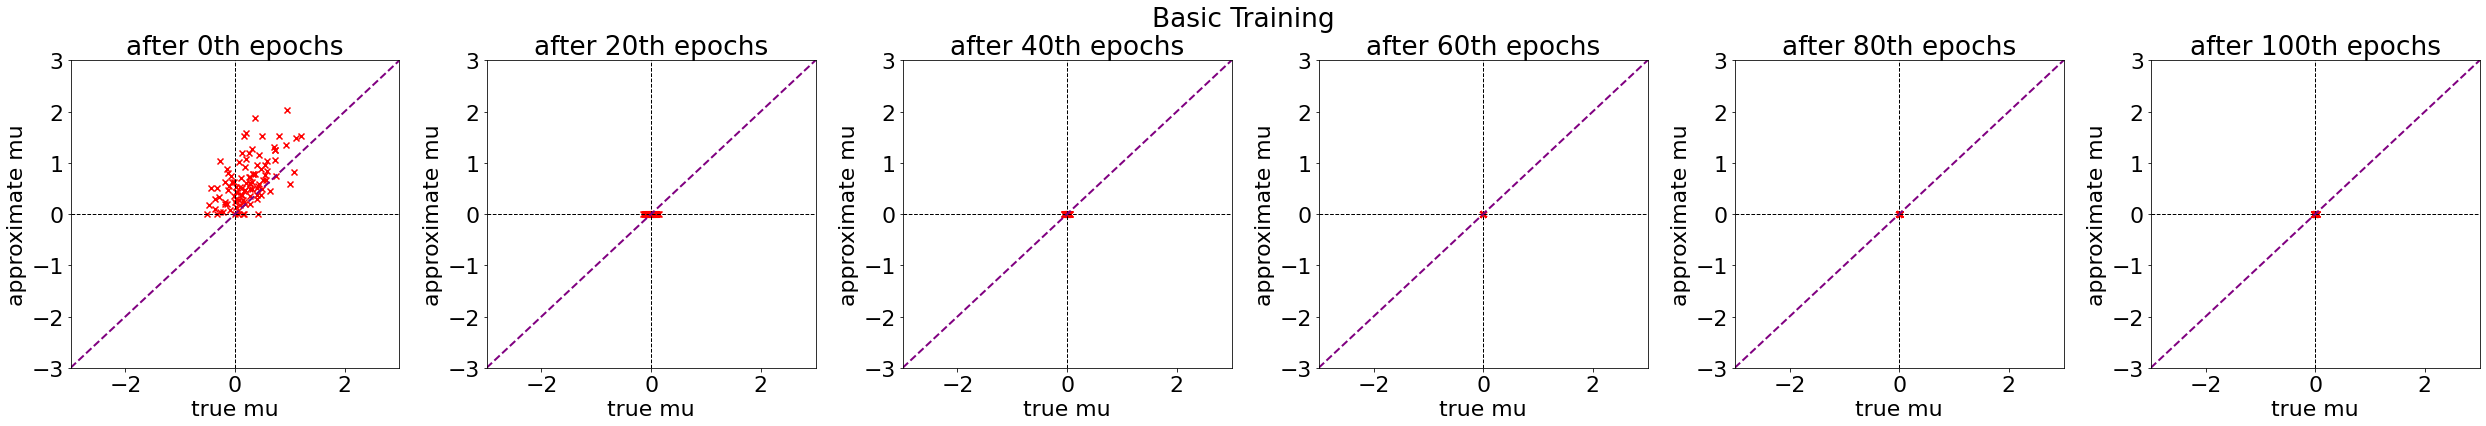

In [23]:
K.clear_session()
tf.random.set_seed(207)

# set constant variables
epochs=100
n_plots = 5

# Instantiate one optimizer for the encoder and another for the decoder.
enc_optimizer = optimizers.RMSprop(learning_rate=0.002)
dec_optimizer = optimizers.RMSprop(learning_rate=0.001)

# trained the VAE till we get a decent encoder & decoder
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder,_, _= comprehensive_training(encoder, decoder, 
                                              enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer,
                                              train_dataset=train_dataset, vae_loss=vae_loss, axes=plt.axes, 
                                              epochs=epochs, n_plots=n_plots, show_plot=False,
                                              min_epochs_aggressive=20, patience=3)
# Basic Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Basic Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")
    
# use trained decoder, and a new untrained encoder
encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  
encoder2, decoder2, _, _, _ = basic_training(encoder_new, decoder, enc_optimizer = enc_optimizer, dec_optimizer =dec_optimizer, 
                                             train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()

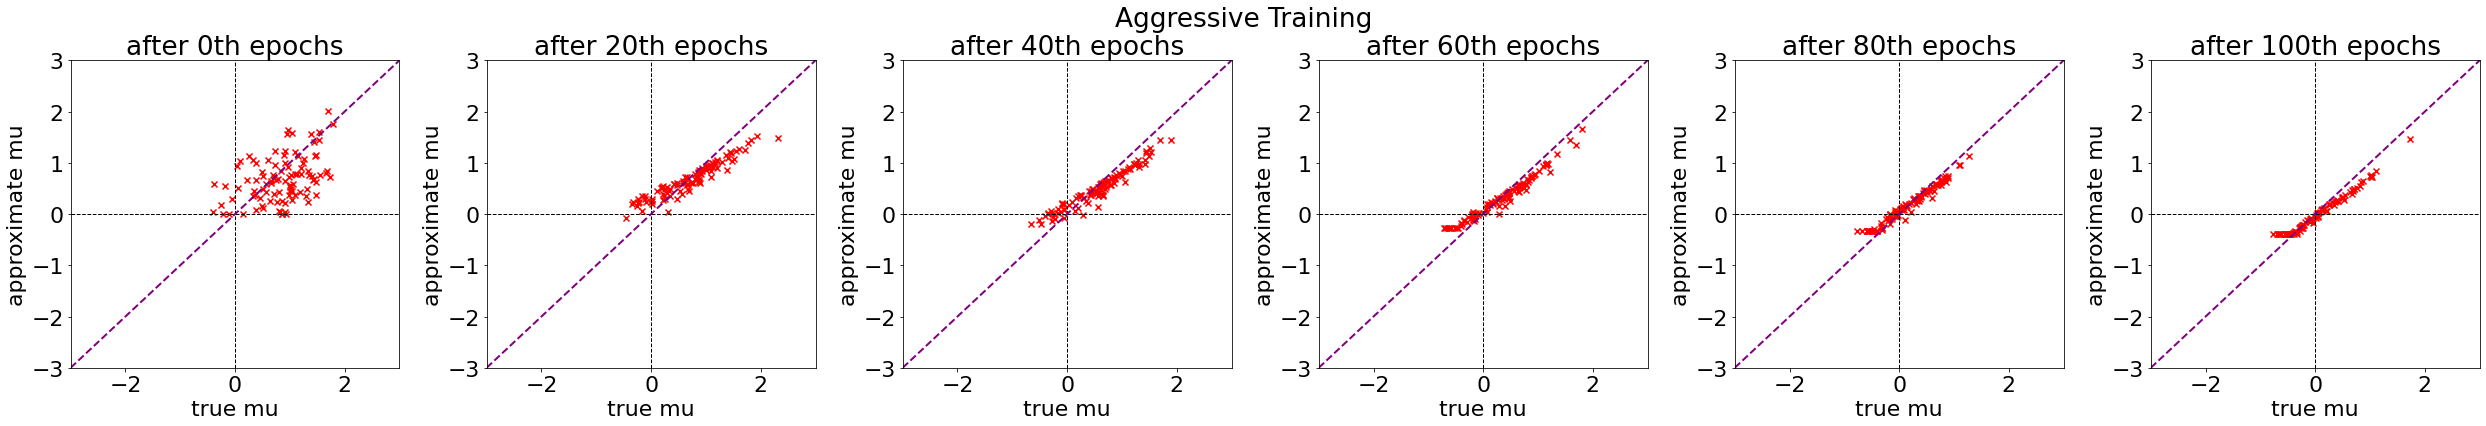

In [24]:
K.clear_session()
tf.random.set_seed(207)

# trained the VAE till we get a decent encoder & decoder
encoder = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)    
decoder = make_decoder(input_dim, dec_intermediate_dim)
encoder, decoder, _, _ = comprehensive_training(encoder, decoder,
                                                enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                train_dataset=train_dataset, vae_loss=vae_loss, axes=plt.axes, 
                                                epochs=epochs, n_plots=n_plots, show_plot=False)
# Agressive Training
fig, axes = plt.subplots(1,n_plots+1,figsize=(35, 6))
fig.suptitle("Aggressive Training", y=1.01)
for i in range(n_plots+1):
    axes[i].set_title(f"after {int(epochs/n_plots)*(i)}th epochs")

# use trained decoder, and a new untrained encoder
encoder_new = make_encoder(input_dim, enc_intermediate_dim, bottleneck_dim)  
encoder2, decoder2,_, _, _,_ = comprehensive_training(encoder_new, decoder,
                                                      enc_optimizer=enc_optimizer, dec_optimizer=dec_optimizer, 
                                                      train_dataset=train_dataset, vae_loss=vae_loss, axes=axes, 
                                                      epochs=epochs, n_plots=n_plots)
plt.tight_layout()
plt.show()

Passed the tests: aggressive training is able to force the new encoder to learn and catch up with the trained decoder while basic training cannot.

#### Test 2: Check for correctness for the VAE

Decoder should be able to generate synthetic data with a similar distribution to the training data (starting with random samples from standard normal prior distribution).

In [25]:
# generate synthetic data for random normal
z_synthetic = np.random.normal(0., 1., size=1000)
np.mean(decoder2.predict(z_synthetic), axis=0)

array([0.9691441, 1.847922 , 2.870482 ], dtype=float32)

Passed the test: The mean of the synthetically generated data is pretty close to the true mean (training data is generated from a multivariate Gaussian distribution with mean $[1,2,3]^T$)

## Experiments

#### Experient 1

In this experiment, we define the encoder to be a 3-layer feedforward neural network where the number of nodes in the three layers is 16, 8, and 2, respectively. And we define the decoder to be a 3-layer feedforward neural nentwork where the number of nodes in the three layers is 2, 12 and 16, respectively. We optimize both the encoder and decoder using RMSprop.

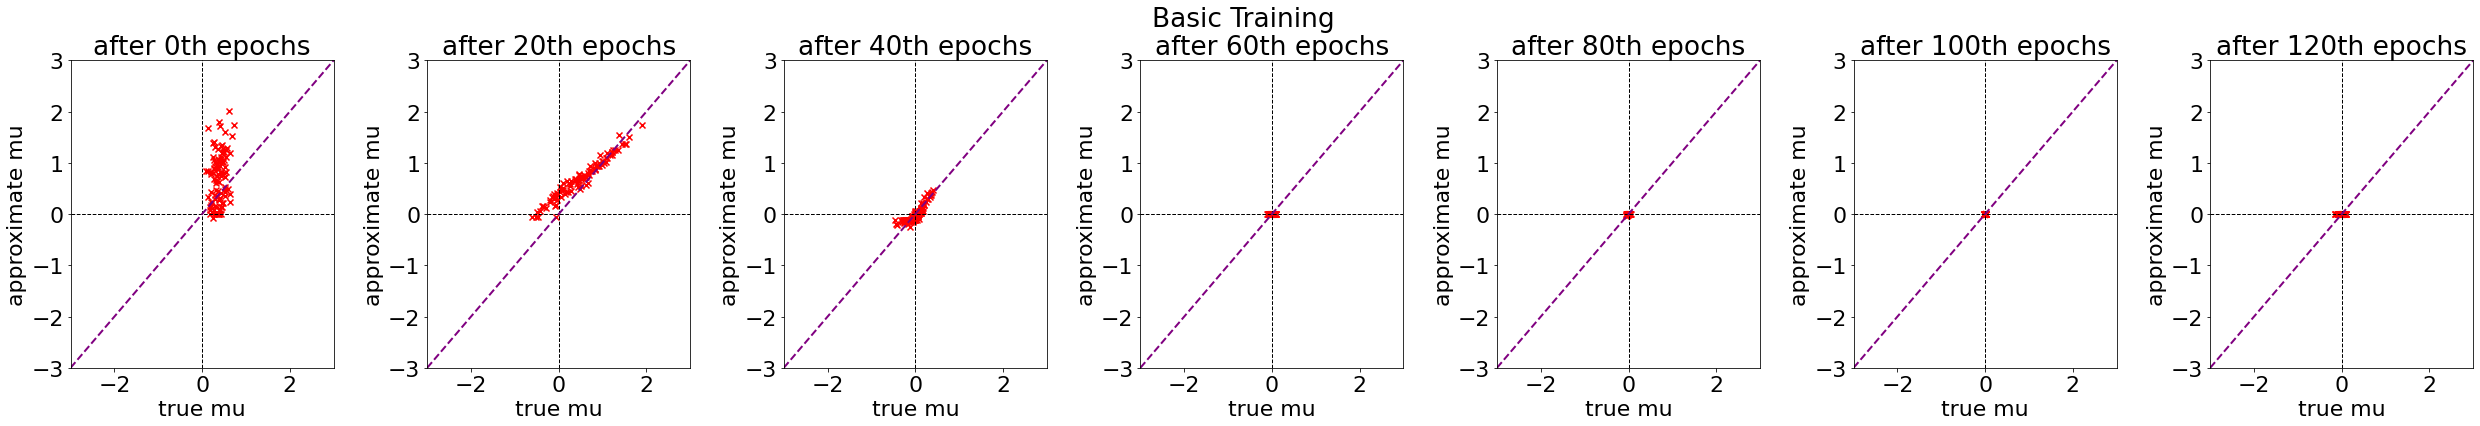

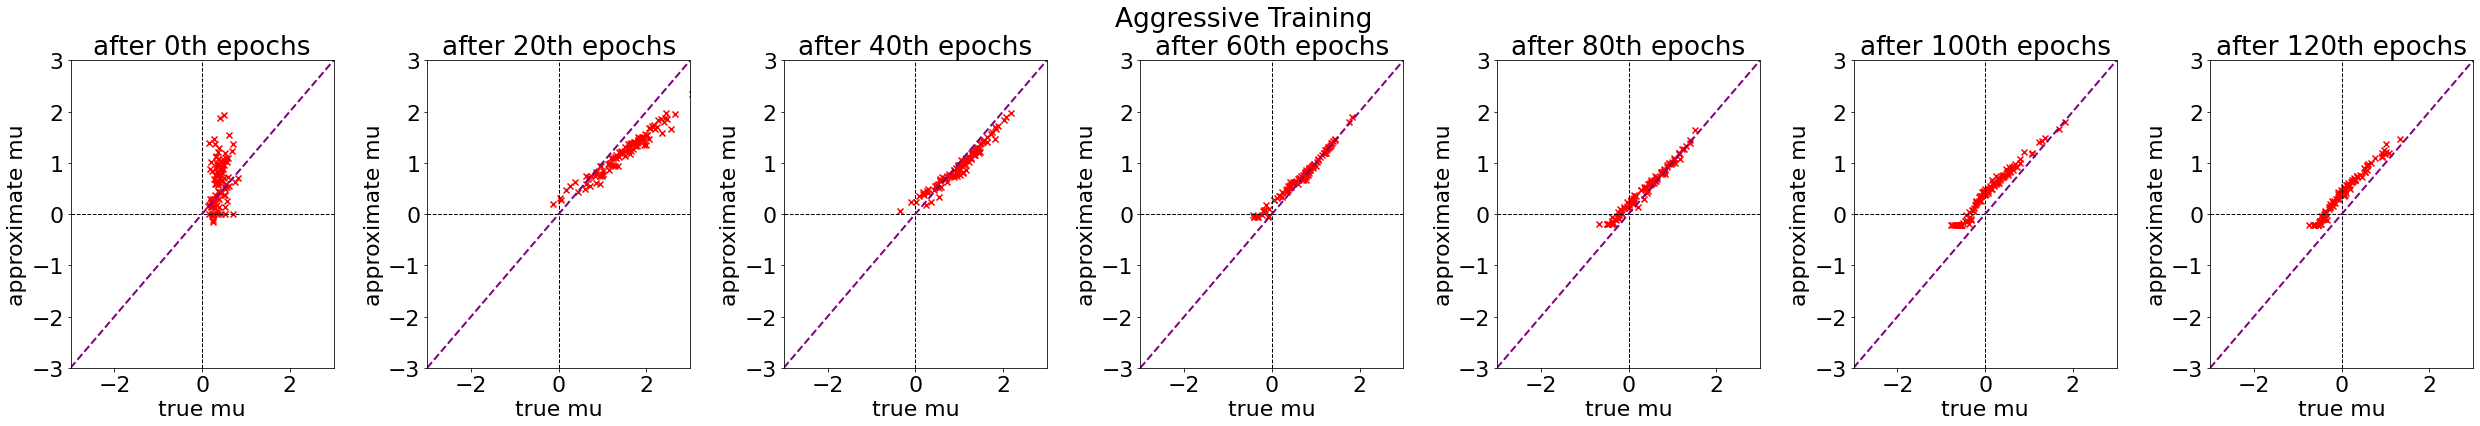

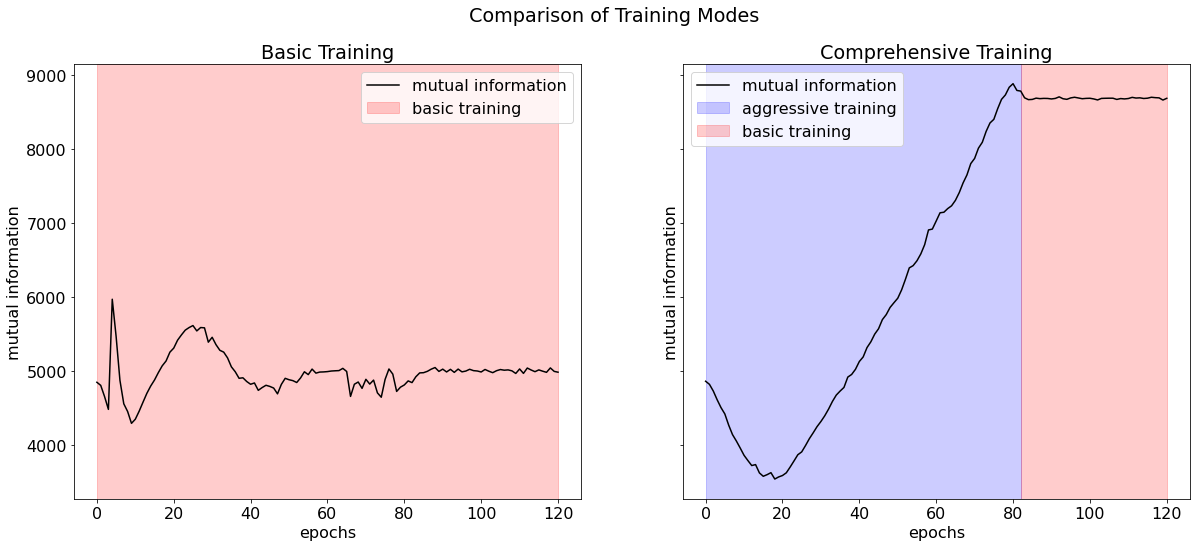

In [26]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

This experiment clearly illustrates how aggressive training can prevent posterior collapse. The top graph shows that during basic training both the true posterior and the approximate posterior rapidly shrink towards the origin,  which indicates that posterior collapse has occurred. On the other hand, the second plot shows that during aggressive training the points quickly orient themselves along the diagonal which indicates that the approximate posterior is in fact doing a good job at mimicking the true posterior. In other words, aggressive training has solved the problem of the encoder lagging behind the decoder. The final plot of the mutual information confirms this. The plot on the left shows that the mutual formation remains roughly constant throughout the entire basic training process. This means that the encoder hasn't learned a meaningful latent representation. In aggressive training, on the other hand, after a brief decrease in the mutual formation, it increases linearly over the course of roughly 70 epochs until it eventually flatlines. This means that the encoder has managed to learn a meaningful latent representation. 

#### Experiment 2

This experiment is identical to experiment 1 except that the encoder is more complex (there are now twice as many nodes in each layer).

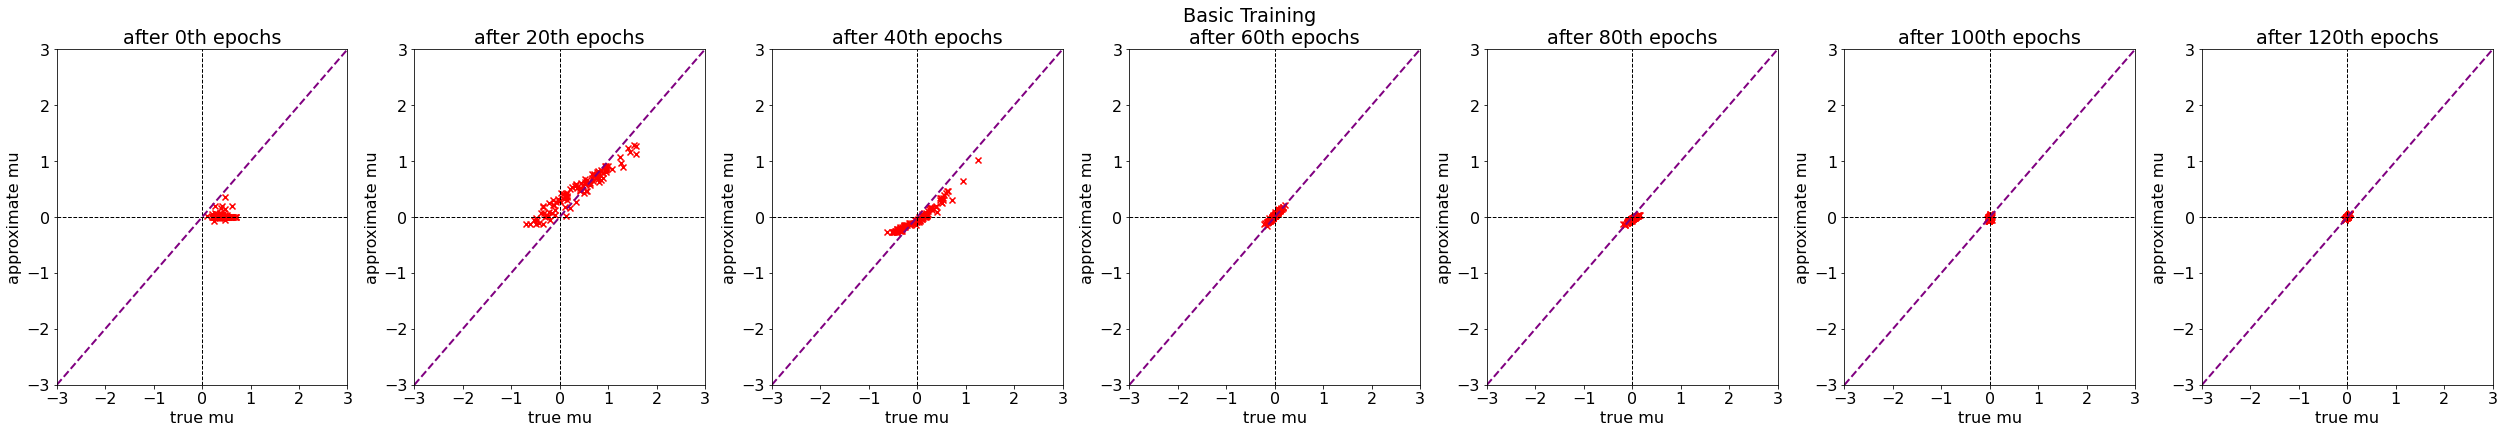

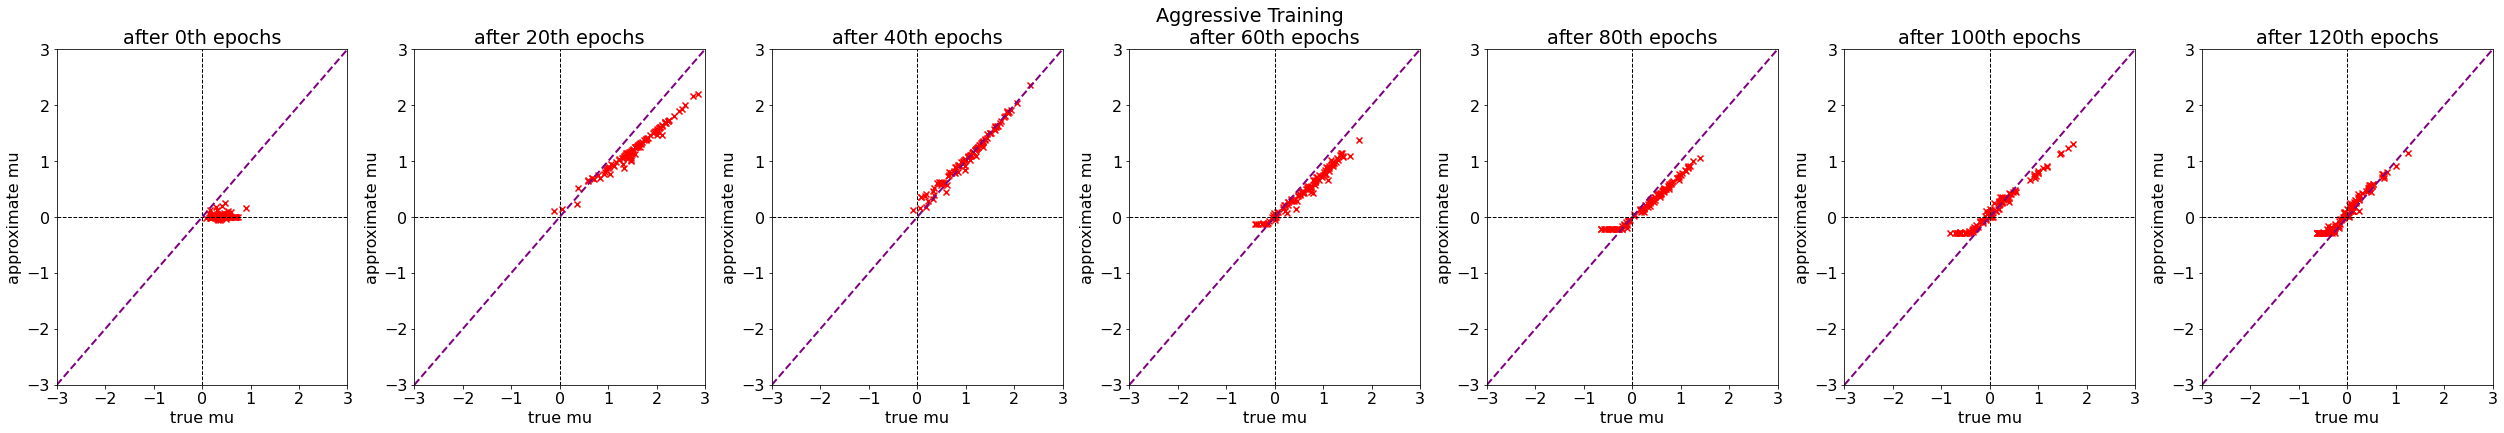

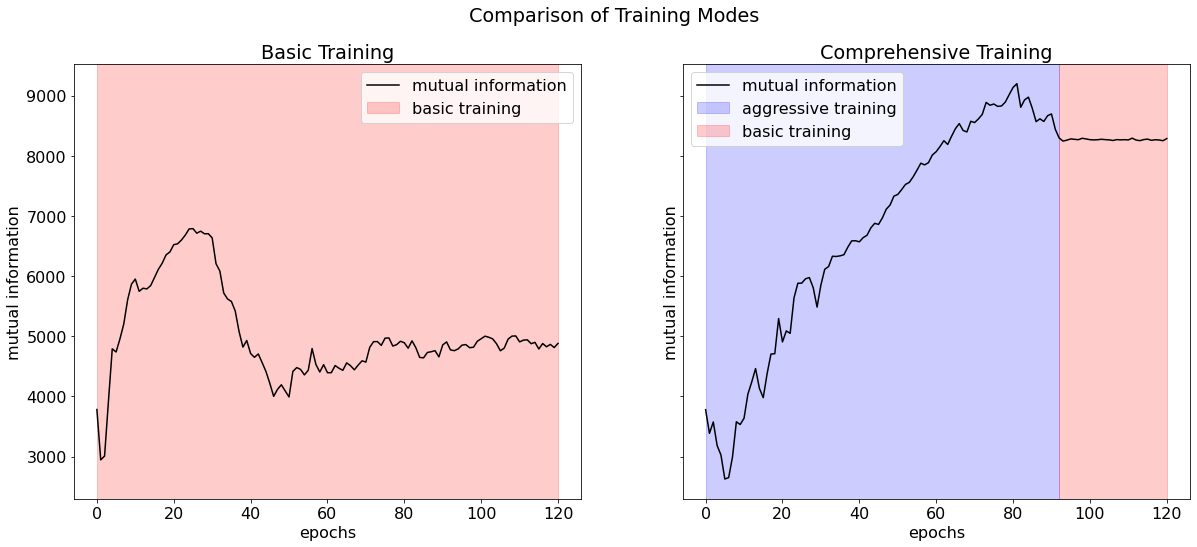

In [27]:
train_vae_given_hyperparameters(enc_intermediate_dim=[32,16,4], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

The fact that the encoder is more complex in this experiment leads to several key differences in the results. First, we notice that under basic training, the points initially fall along a diagonal and the mutual information initially increases. However, after around 20 epochs the model begins to collapse, as the points slowly shrink towards the origin and the mutual information declines significantly. On the other hand, under aggressive training, posterior collapse is once again avoided. The only difference here is that the mutual information plateaus after roughly half the number of iterations that it took an experiment 1. None of these observations is surprising because it's easier for the encoder to keep up with the decoder as the complexity of the encoder increases. 

#### Experiment 3

This experiment is identical to experiment 1 except that the encoder is less complex (there are now half as many nodes in each layer).

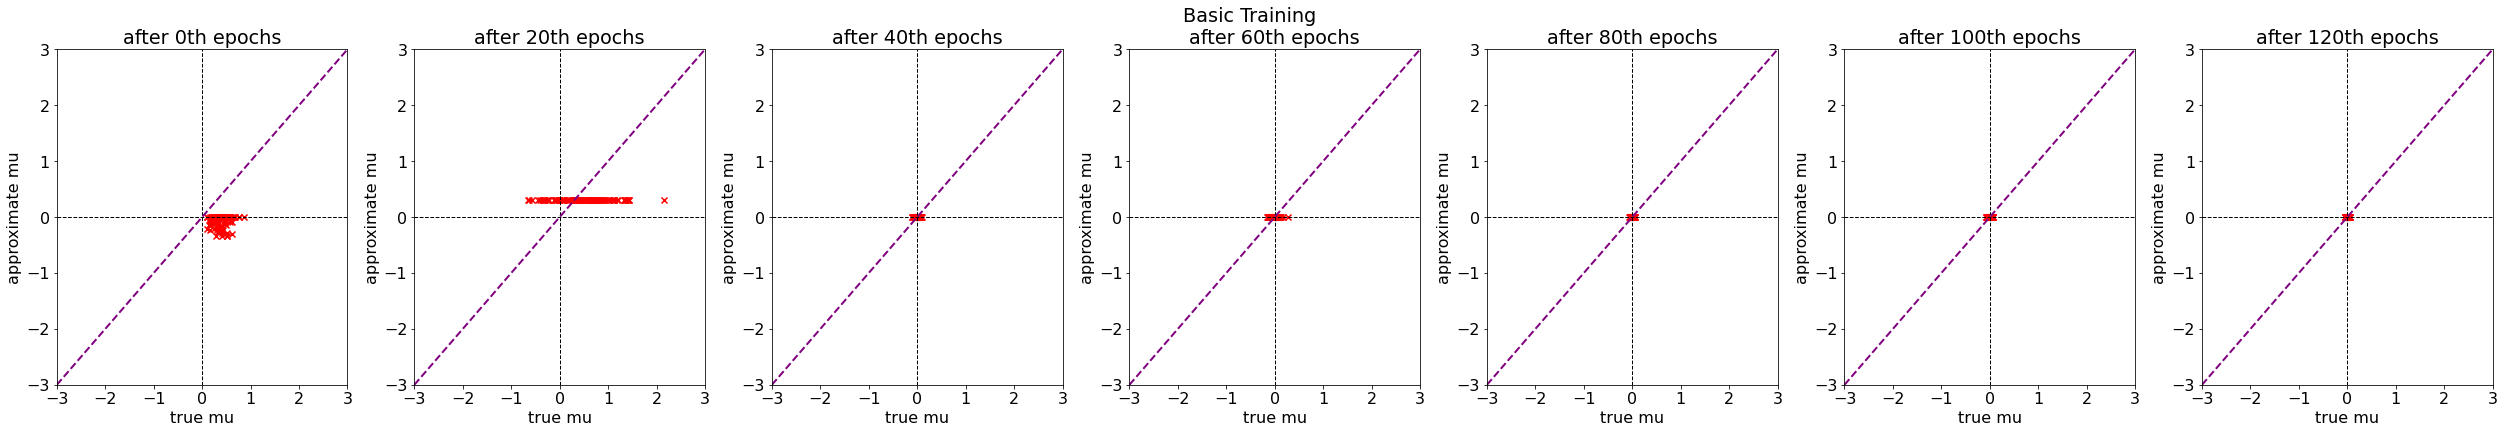

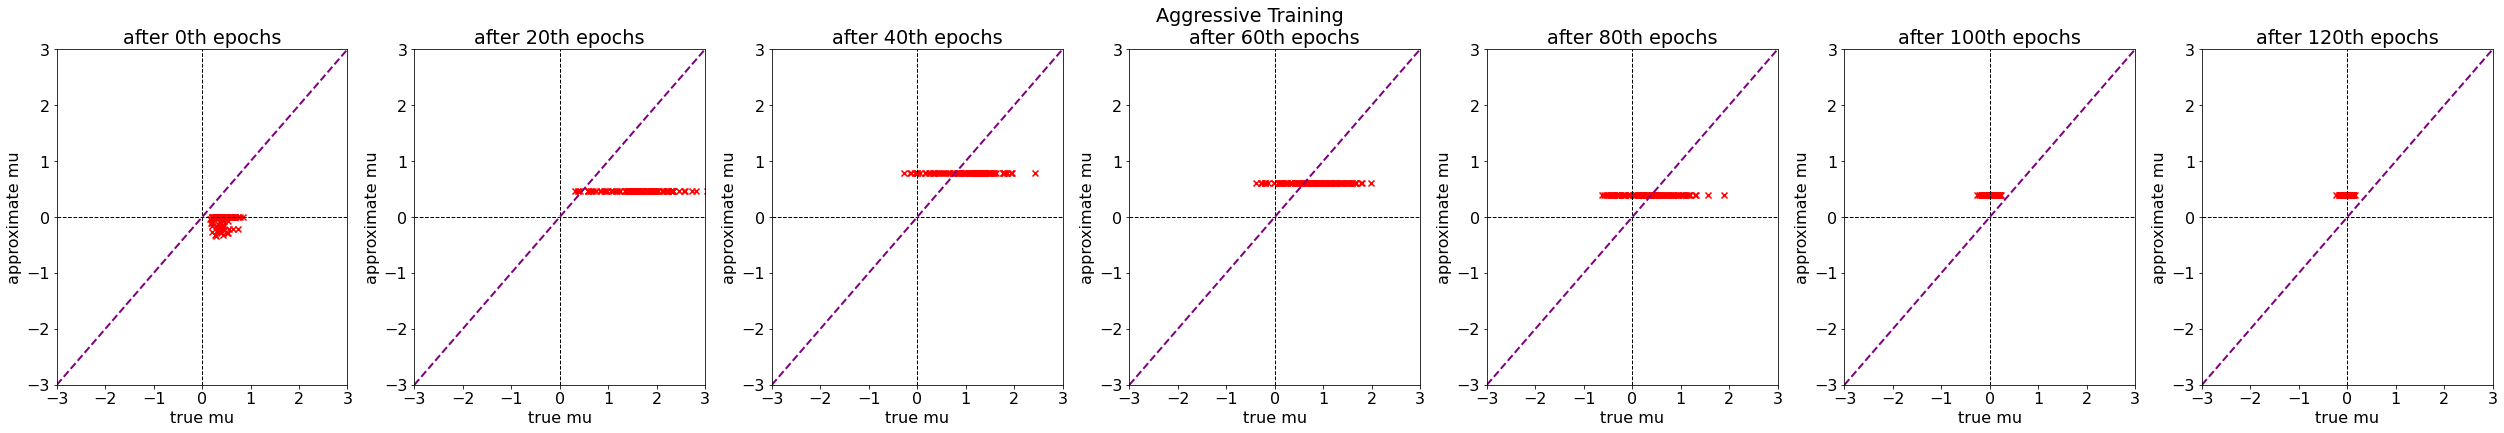

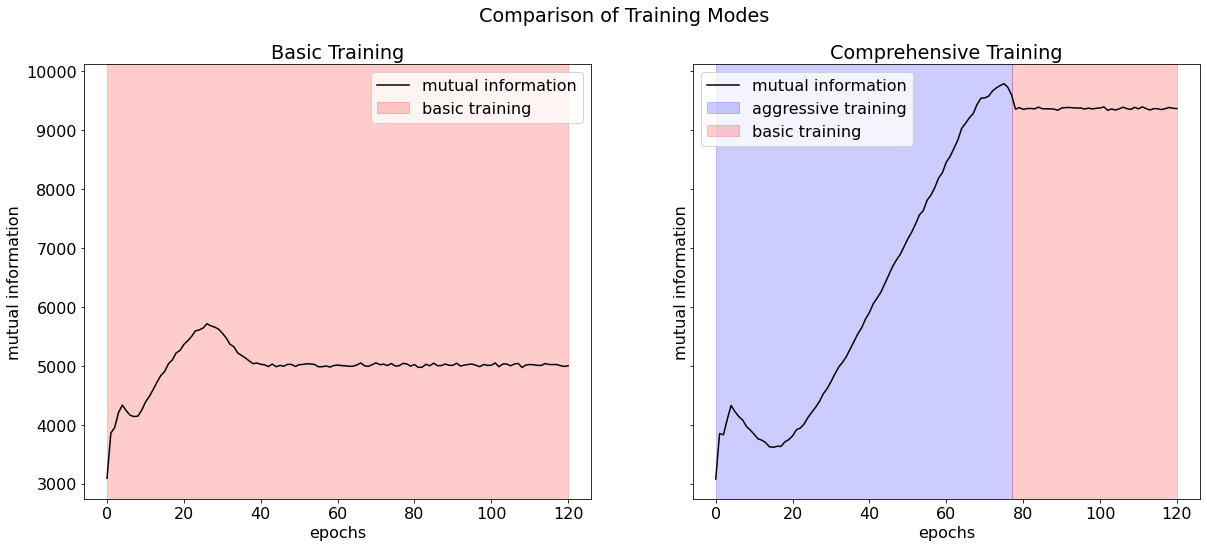

In [31]:
train_vae_given_hyperparameters(enc_intermediate_dim=[8,4,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

As expected, under basic training the model once again reaches a state of posterior collapse. What's different is that posterior collapse occurs even under aggressive training (at least according to the plot of the true posterior mean vs. the approximate posterior mean. Surprisingly, the mutual information plot contradicts this plot and suggests that the encoder has still managed to learn a meaningful latent representation of the data. But because the  posterior mean plot is more directly indicative of posterior collapse, it’s safe to assume that collapse has in fact taken place.)  Thus, this experiment demonstrates a case where aggressive training is unable to prevent posterior collapse. The reason for this is quite simple: if the inference network isn’t complex enough, it doesn’t have the flexibility needed to learn an approximate posterior distribution that adequately mimics the true posterior distribution -- and this is not a problem that can be solved by simply emphasizing the training of the encoder. 

To give an analogy, aggressive training is like a tutor. If a student is already familiar with the material,  then having a tutor spend more time reviewing the material could help improve the student’s understanding. However, if the student has never learned the material in the first place, then no matter how many extra practice problems the tutor gives the student, the student will never be able to master the material. 

#### Experiment 4

This experiment is identical to experiment 1 except that the learning rates have been changed (encoder learning rate has been increased by 4x, while decoder learing rate has been increased by 5x).

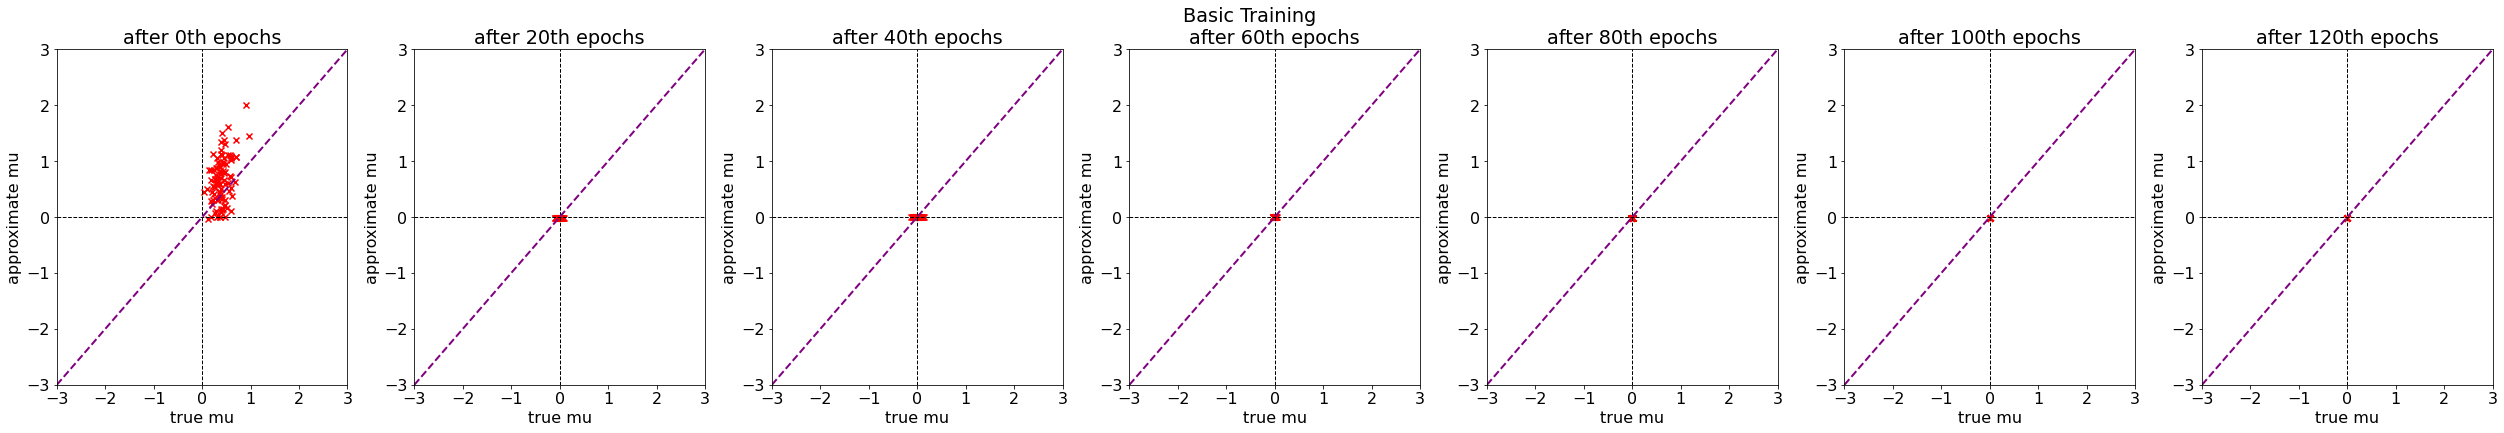

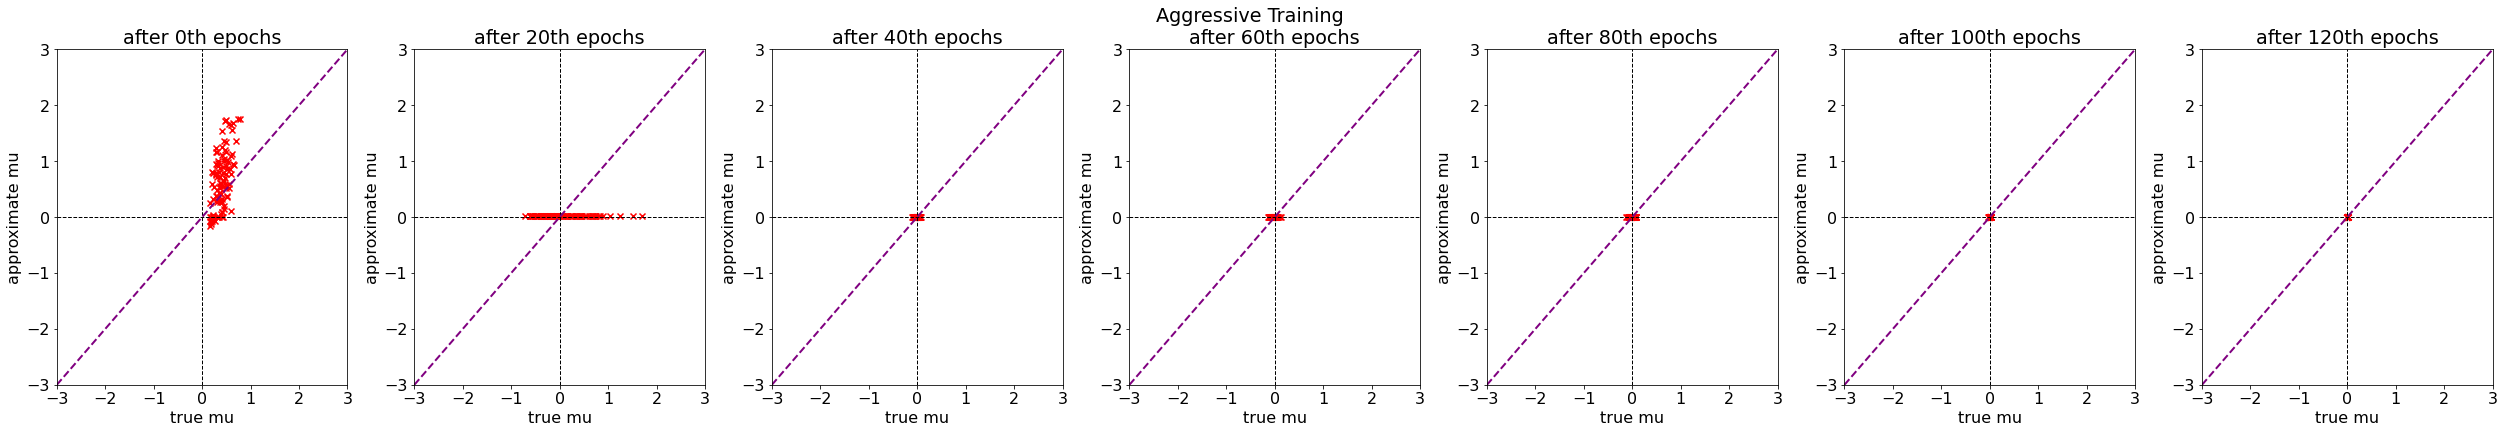

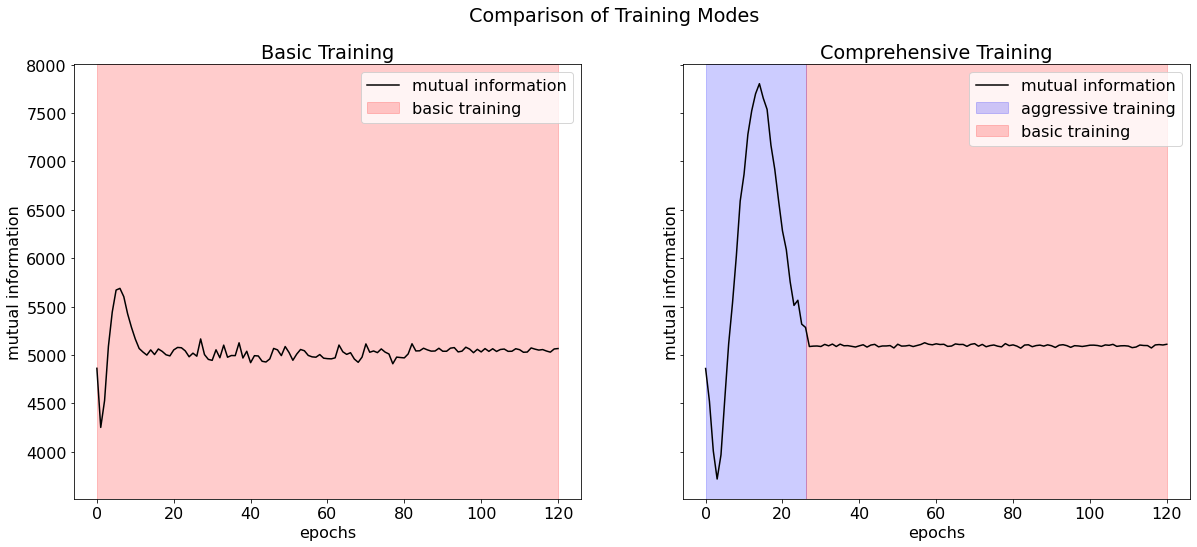

In [29]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.02,
                                dec_learning_rate=0.01,
                                encoder_optimizer=optimizers.RMSprop,
                                decoder_optimizer=optimizers.RMSprop)

This experiment shows that like most deep learning models,  the performance of the VAE is highly sensitive to the chosen hyperparameters. In this case, changing the learning rates by less than an order of magnitude leads to posterior collapse even under aggressive training.

#### Experiment 5

This experiment is identical to experiment 1 except that the optimizer has been changed from RMSprop to Adam for both the encoder and decoder.

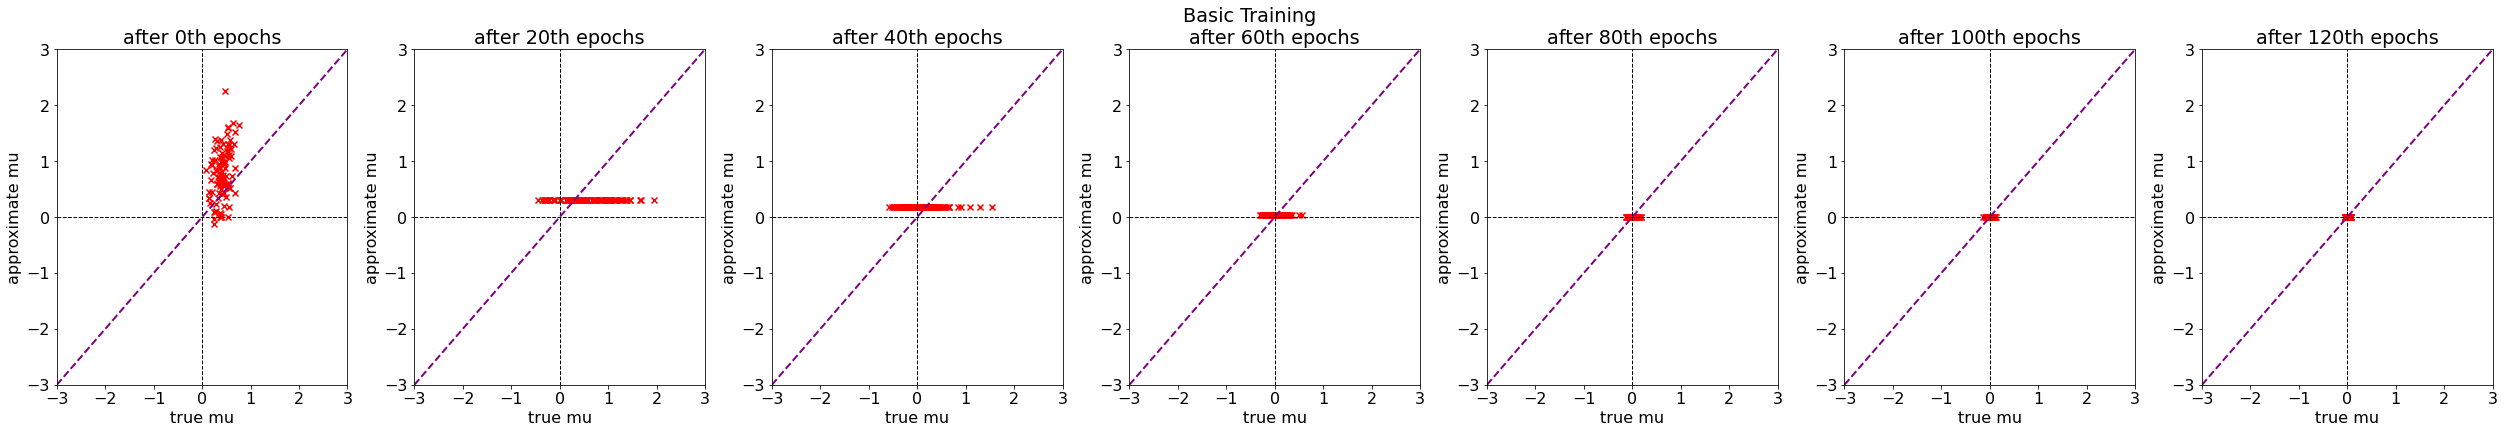

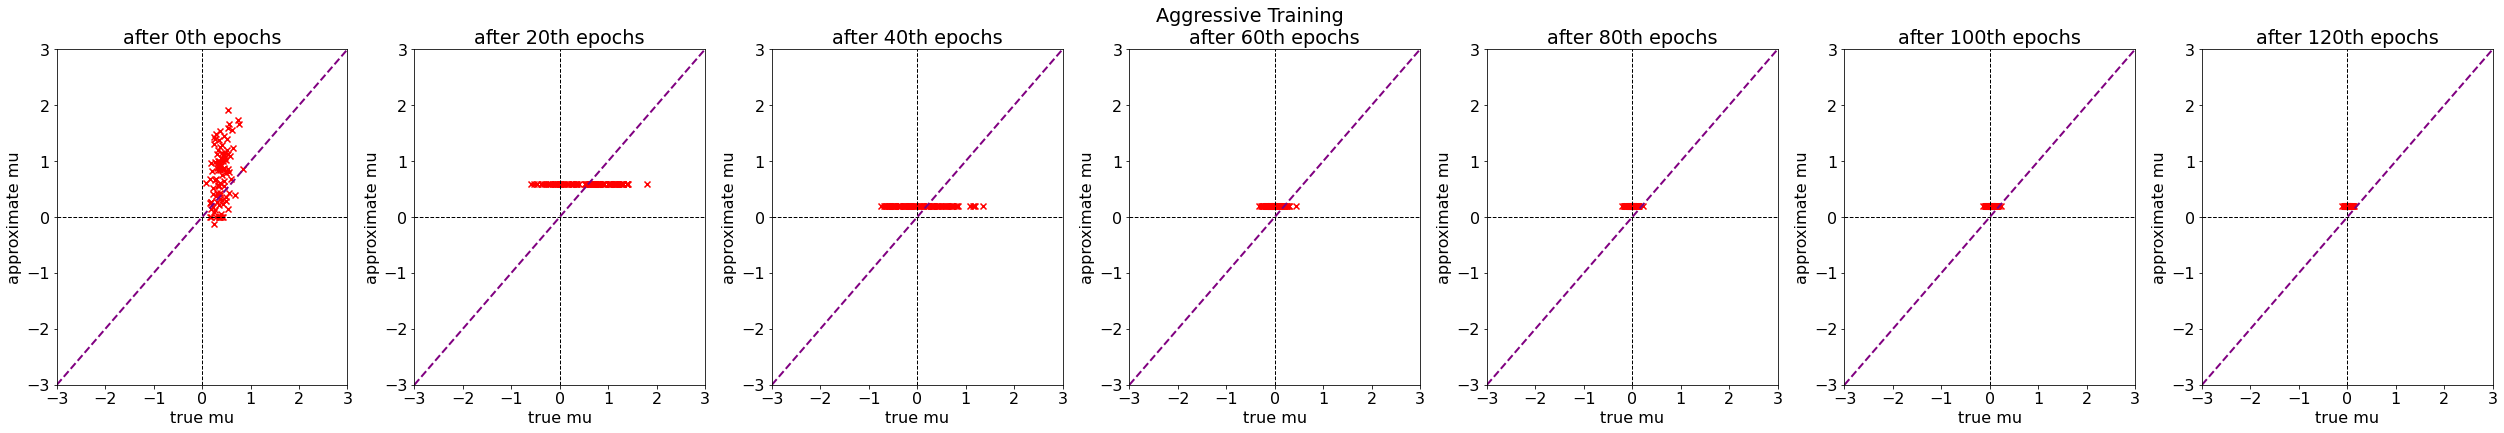

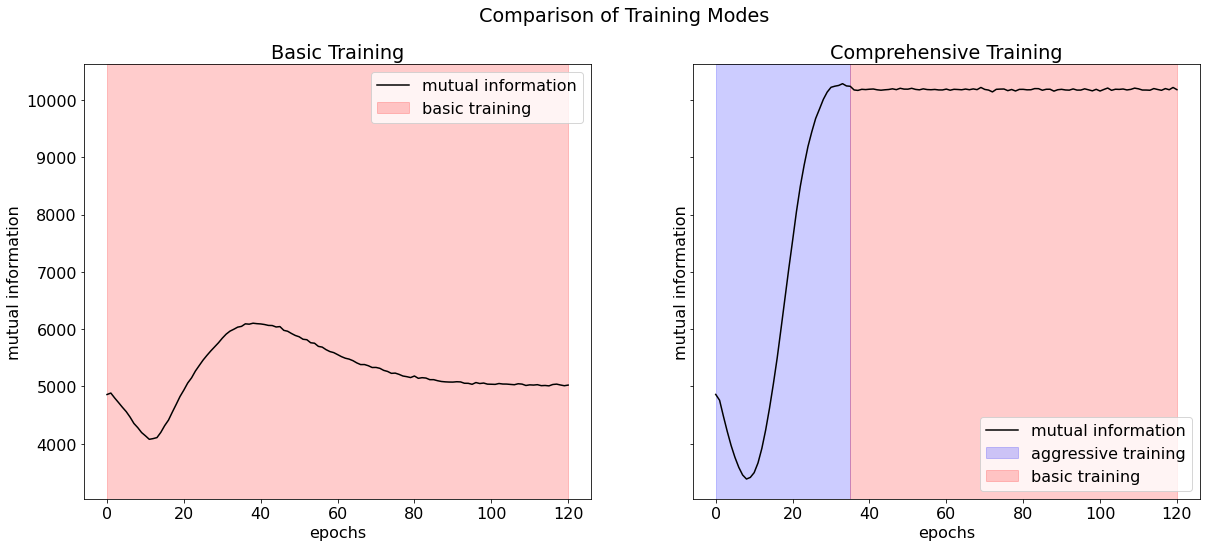

In [30]:
train_vae_given_hyperparameters(enc_intermediate_dim=[16,8,2], 
                                enc_learning_rate=0.005,
                                dec_learning_rate=0.002,
                                encoder_optimizer=optimizers.Adam,
                                decoder_optimizer=optimizers.Adam)

This experiment offers another example of how the performance of the VAE depends strongly on how the network is designed. In this case, simply replacing RMSprop with Adam is enough to cause posterior collapse under aggressive training. 